# Fine-tuning for Function calling on custom data.

**⏱️ Time to complete**: 5 hours for 7/8B models (11 hours for 13B, 27 hours for 70B)

Function calling is an important capability of large language models. Connecting your model to external tools is at the heart of many LLM applications. In Anyscale Endpoints, you can use the [function calling API](https://docs.anyscale.com/preview/endpoints/text-generation/function-calling) to enable any model to use external tools. This is made possible [through JSON mode](https://www.anyscale.com/blog/anyscale-endpoints-json-mode-and-function-calling-features). However, it is beneficial to have *native* function calling capabilities in your model through fine-tuning on a relevant function calling dataset. JSON-mode-based function calling can only guarantee that the output is in the right schema, and can also be more expensive than a regular chat completion. However, fine-tuning on a function calling dataset can improve the model's capabilities with intent recognition (understanding when to call and when not to call a tool) and function call accuracy (employing the right function with accurate parameters) in addition to structured data formatting (formatting the function call json in the correct schema).  Fine-tuning would also be the only systematic way to improve performance on use-case-specific data. 

In this example, we demonstrate fine-tuning on [Glaive's function calling dataset](https://huggingface.co/datasets/glaiveai/glaive-function-calling-v2?row=0) using Anyscale Endpoints. The dataset consists of about 113,000 examples of synthetically generated function calling data.  The dataset composition is given below:

<p align="center">
  <img src="./assets/distr_glaive_pie.png" alt="Distribution">
</p>


# Table of Contents
1. [Data Preprocessing](#data-preprocessing)
2. [Finetuning](#fine-tuning-with-anyscale-endpoints)
3. [Serving](#serving)
4. [Evaluation](#evaluation)

First, let's make the necessary imports

In [133]:
# necessary imports
import datasets
import ray.data 
import sys
import pprint
import json 
import re
from tqdm import tqdm
import openai

In [ ]:
from fc_utils.preprocessing import initial_mapper, pprint_example, preprocess, save_to_jsonl
from fc_utils.response_parsers import OpenAIResponseParser, AnyscaleResponseParser
from fc_utils.eval_utils import evaluate_gpt, evaluate_finetuned
from fc_utils.test_utils import test_data_mapper
from fc_utils.plot_utils import plot_results

# Step 1: Data Preprocessing
We'll use Ray Data for scalable data processing. First let's load the dataset from the HuggingFace Hub and inspect a few entries

In [2]:
hf_ds = datasets.load_dataset("glaiveai/glaive-function-calling-v2", split="train").shuffle(seed=21) 
hf_ds_subset =  hf_ds.select(range(int(len(hf_ds)*0.10))) # sample only 10% of the dataset
ray_ds = ray.data.from_huggingface(hf_ds_subset)

2024-05-15 17:18:55,438	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [124]:
pprint_example(ray_ds.take(1)[0])

2024-05-16 10:36:55,566	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-05-15_17-18-53_424889_8313/logs/ray-data
2024-05-16 10:36:55,567	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1]


- limit=1 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

system: SYSTEM: You are a helpful assistant with access to the following functions. Use them if required -
{
    "name": "create_reminder",
    "description": "Create a reminder for a specific date and time",
    "parameters": {
        "type": "object",
        "properties": {
            "reminder_text": {
                "type": "string",
                "description": "The content of the reminder"
            },
            "reminder_date": {
                "type": "string",
                "format": "date",
                "description": "The date of the reminder"
            },
            "reminder_time": {
                "type": "string",
                "format": "time",
                "description": "The time of the reminder"
            }
        },
        "required": [
            "reminder_text",
            "reminder_date",
            "reminder_time"
        ]
    }
}

chat: USER: I need to set a reminder for my doctor's appointment.


ASSISTANT: Sure, I can help wit

If you notice, each sample has two entries: system and chat. This dataset is already formatted in specific way (e.g. using USER, \<|endoftext|\> and other tokens). To enable fine-tuning on various open source models we need to convert each row to a more general format like the OpenAI chat format, which is the preferred format for fine-tuning instruction-tuned models on Anyscale ([dataset format guide](https://docs.endpoints.anyscale.com/endpoints/fine-tuning/dataset-prep)). Let's first bring this dataset into the conversation format and inspect how that looks like:

In [134]:
# initial preprocessing to get to the conversation format
openai_fmt_ds = ray_ds.map(initial_mapper)
pprint_example(openai_fmt_ds.take(1)[0], keys=["messages", "tools"]) # inspect one example

2024-05-16 10:54:20,528	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-05-15_17-18-53_424889_8313/logs/ray-data
2024-05-16 10:54:20,529	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(initial_mapper)] -> LimitOperator[limit=1]


- Map(initial_mapper) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

system: You are a helpful assistant.
user: Hi, I need help with calculating the tip for my bill. The total amount is $50 and I want to give a 20% tip.
assistant: [TOOL_CALLS] [ {"name": "calculate_tip", "arguments": '{"total": 50, "tip_percentage": 20}'} ] [/TOOL_CALLS]
tool: [{"tip_amount": 10}]
assistant: Based on the total bill amount of $50 and a tip percentage of 20%, the tip amount you should give is $10. 
Tool list: [{"name": "calculate_tip", "description": "Calculate the tip amount based on bill total and tip percentage", "parameters": {"type": "object", "properties": {"total": {"type": "number", "description": "The total bill amount"}, "tip_percentage": {"type": "number", "description": "The percentage of tip to be given"}}, "required": ["total", "tip_percentage"]}}]



Notice how we made use of special indicators "\[TOOL_CALLS\]" and "\[/TOOL_CALLS\]" to denote a tool call (as supposed a regular JSON output from the model). We'll now further process this conversation format and make it compatible with Anyscale Endpoints. The role "tool" will be converted to the role "user" with a special indicator to highlight that this is a tool response. Further, the tool list will be included in the system prompt with special indicators. The following code block handles the necessary preprocessing.

In [126]:
# complete preprocessing step
processed_ds = preprocess(ray_ds) 
pprint_example(processed_ds.take(1)[0]) # inspect one example

2024-05-16 10:40:54,923	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-05-15_17-18-53_424889_8313/logs/ray-data
2024-05-16 10:40:54,924	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(final_mapper)->Filter(filter_func)->MapBatches(drop_columns)] -> LimitOperator[limit=1]


- Map(final_mapper)->Filter(filter_func)->MapBatches(drop_columns) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- limit=1 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

system: You are a helpful assistant.[TOOL_LIST] [{"name": "get_stock_price", "description": "Get the current stock price", "parameters": {"type": "object", "properties": {"symbol": {"type": "string", "description": "The stock symbol, e.g. AAPL"}}, "required": ["symbol"]}},{"name": "calculate_mortgage_payment", "description": "Calculate the monthly mortgage payment based on loan details", "parameters": {"type": "object", "properties": {"loan_amount": {"type": "number", "description": "The amount of the loan"}, "interest_rate": {"type": "number", "description": "The annual interest rate"}, "loan_term": {"type": "integer", "description": "The loan term in years"}}, "required": ["loan_amount", "interest_rate", "loan_term"]}}] [/TOOL_LIST]
user: Can you tell me the current stock price of AAPL?
assistant: [TOOL_CALLS] [ {"name": "get_stock_price", "arguments": '{"symbol": "AAPL"}'} ] [/TOOL_CALLS]
user: [TOOL_RESULTS] [{"status": "success", "data": {"symbol": "AAPL", "price": 150.75}}] [/TOO

Let's make a train, validation and test split and save the datasets in the `jsonl` format.

In [6]:
train_ds, val_ds, test_ds = processed_ds.split_proportionately([0.8, 0.1])
test_ds, _  = test_ds.split_at_indices([200]) # restrict to 200 examples for testing

2024-05-15 17:19:04,543	INFO streaming_executor.py:112 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-05-15_17-18-53_424889_8313/logs/ray-data
2024-05-15 17:19:04,543	INFO streaming_executor.py:113 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(final_mapper)->Filter(filter_func)->MapBatches(drop_columns)]


- Map(final_mapper)->Filter(filter_func)->MapBatches(drop_columns) 1:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# inspect final counts
train_ds.count(), val_ds.count(), test_ds.count()

(9036, 1129, 200)

In [8]:
# save the datasets to jsonl format
save_to_jsonl(train_ds, "glaiveai-function-calling-v2-train.jsonl")
save_to_jsonl(val_ds, "glaiveai-function-calling-v2-val.jsonl")
save_to_jsonl(test_ds, "glaiveai-function-calling-v2-test.jsonl")

# Step 2: Fine-tuning 

For fine-tuning, you have two options with Anyscale:
1. Fine-tuning on the Anyscale Platform through our fine-tuning template 
    - This would be the preferred route for those wishing to get more flexibility in choice of models and hyperparameters, better monitoring, etc.
2. Fine-tuning through Anyscale's serverless endpoints
    - A quick and easy way to fine-tune a model via an OpenAI compatiable SDK.

For this guide, we will use `Llama-3-8B-Instruct` as the base model for fine-tuning.



## Step 2(a): Fine-tuning on the Anyscale Platform

Head over to the Anyscale Platform: https://console.anyscale.com/v2 and spin up the "Fine-tune LLMs" template (under "AI application templates")

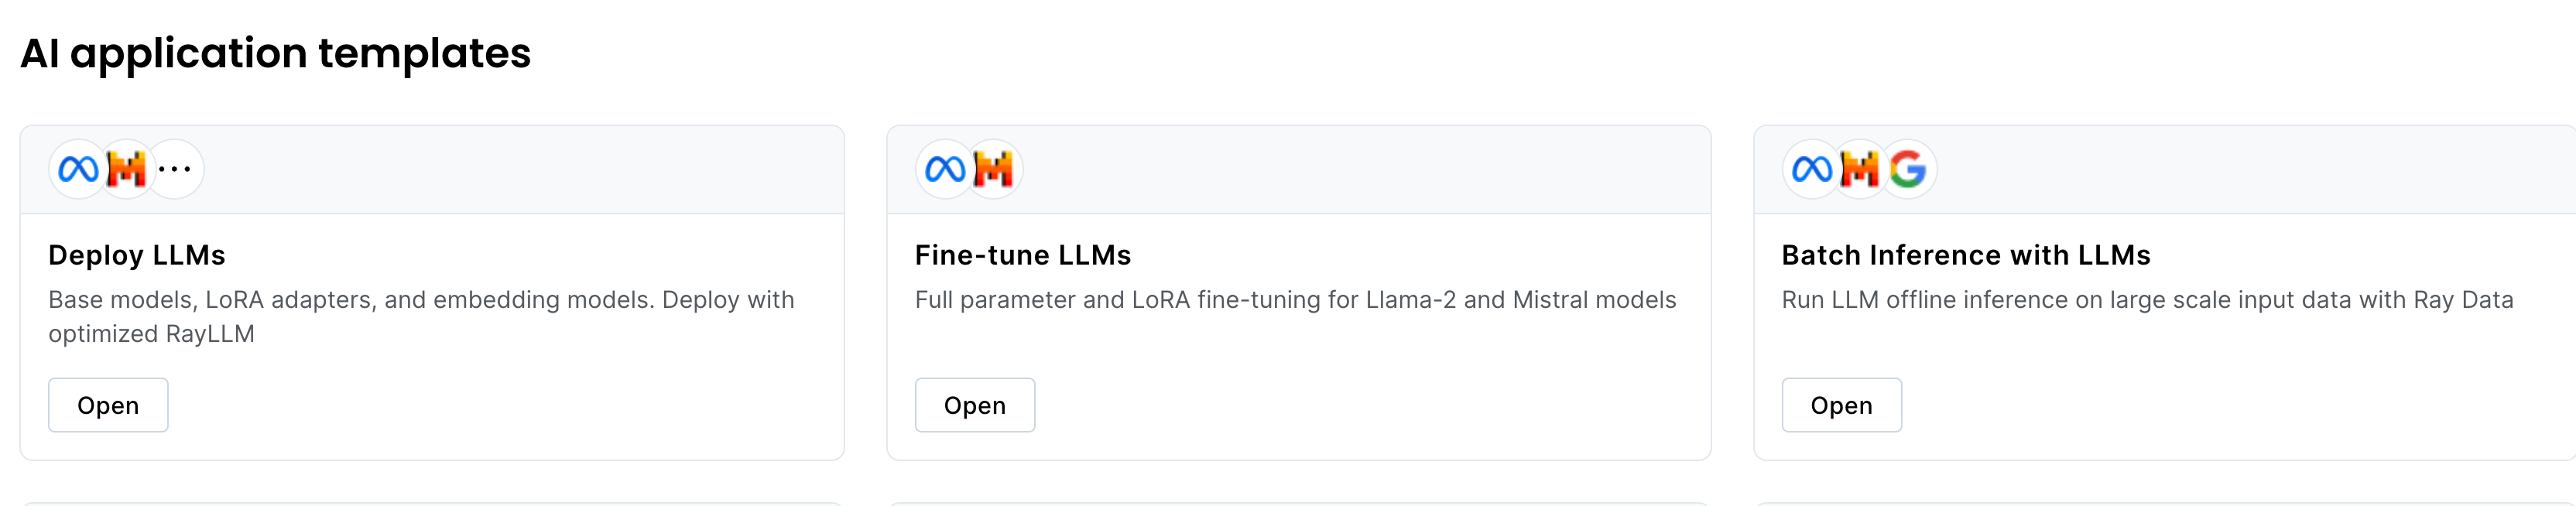


Follow the instructions to run your fine-tuning job.

## Step 2(b): Fine-tuning through serverless endpoints
First, obtain your credentials from the [Anyscale platform](https://console.anyscale.com/v2/) and upload the training and validation files in the [fine-tuning tab](https://console.anyscale.com/v2/fine-tuning?fine-tuning-tab=files). Make a note of the file IDs for each. This will be passed to the fine-tuning job.

In [10]:
ANYSCALE_API_KEY = "esecret_yourKeyHere"  # from https://console.anyscale.com/credentials
ANYSCALE_API_BASE = "https://api.endpoints.anyscale.com/v1"

In [1]:
# Anyscale Endpoints are OpenAI compatible
client = openai.OpenAI(
    base_url = ANYSCALE_API_BASE,
    api_key = "esecret_yourKeyHere" 
)

Let's now launch a fine-tuning job for 4 epochs. The expected time for this job is < 3 hours.

In [ ]:
# other parameters like context length will be chosen appropriately based on dataset size
client.fine_tuning.jobs.create(
    model="meta-llama/Meta-Llama-3-8B-Instruct",
    hyperparameters={"n_epochs": 4},
    # replace with the actual file ids!
    training_file="file_trainingFileId",
    validation_file="file_validationFileId",
)

# Step 3: Serving

## Step 3(a): Finetuned on the Anyscale Platform

Make a note of the final checkpoint after fine-tuning (this should be the last line in the logs). You can now spin up the "Deploy LLMs" template which has all the instructions and required dependencies to serve your finetuned model efficiently. You will find the tutorials on [serving LoRA models](https://github.com/anyscale/templates/blob/main/templates/endpoints_v2/examples/lora/DeployLora.ipynb) (if applicable) and on deploying a [custom model](https://github.com/anyscale/templates/blob/main/templates/endpoints_v2/examples/CustomModels.ipynb) helpful. Once you have set up your fine-tuned model as an Anyscale Service, note down the base URL and API key and place them here.

In [ ]:
# to be run only if you finetuned on the Anyscale platform
ANYSCALE_API_KEY="service-api-key-here"
ANYSCALE_API_BASE="service-url-here" 
if not ANYSCALE_API_BASE.endswith("/"):
    ANYSCALE_API_BASE += "/"
ANYSCALE_API_BASE += "v1"
# enter the model id here. This would be different depending on whether you performed LoRA or full parameter fine-tuning.
# Example: meta-llama/Meta-Llama-3-8B-Instruct:mysuffix:myid 
MODEL_ID = "ModelIdHere"

## Step 3(b): Finetuned through serverless endpoints

To serve the fine-tuned model, you just need to navigate to the "Serving" section on the Anyscale Platform. Your fine-tuned model should already be visible in the list of available models! 

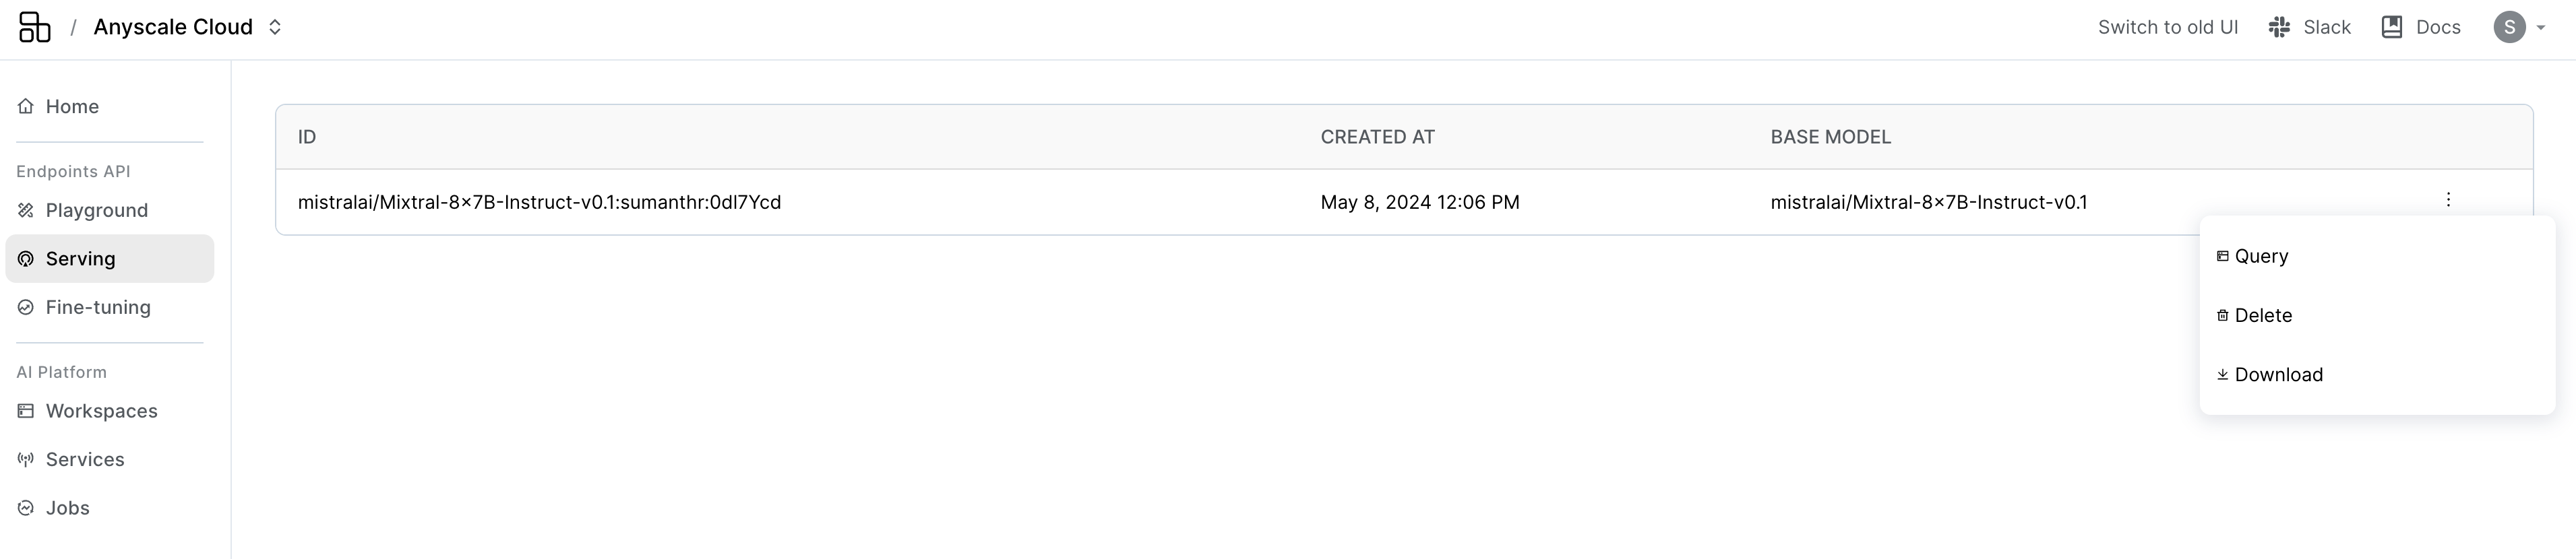

As in the above image, click on the three dots and then click on "Query". This will provide you the starter code to interact with the model via curl, python, etc. 

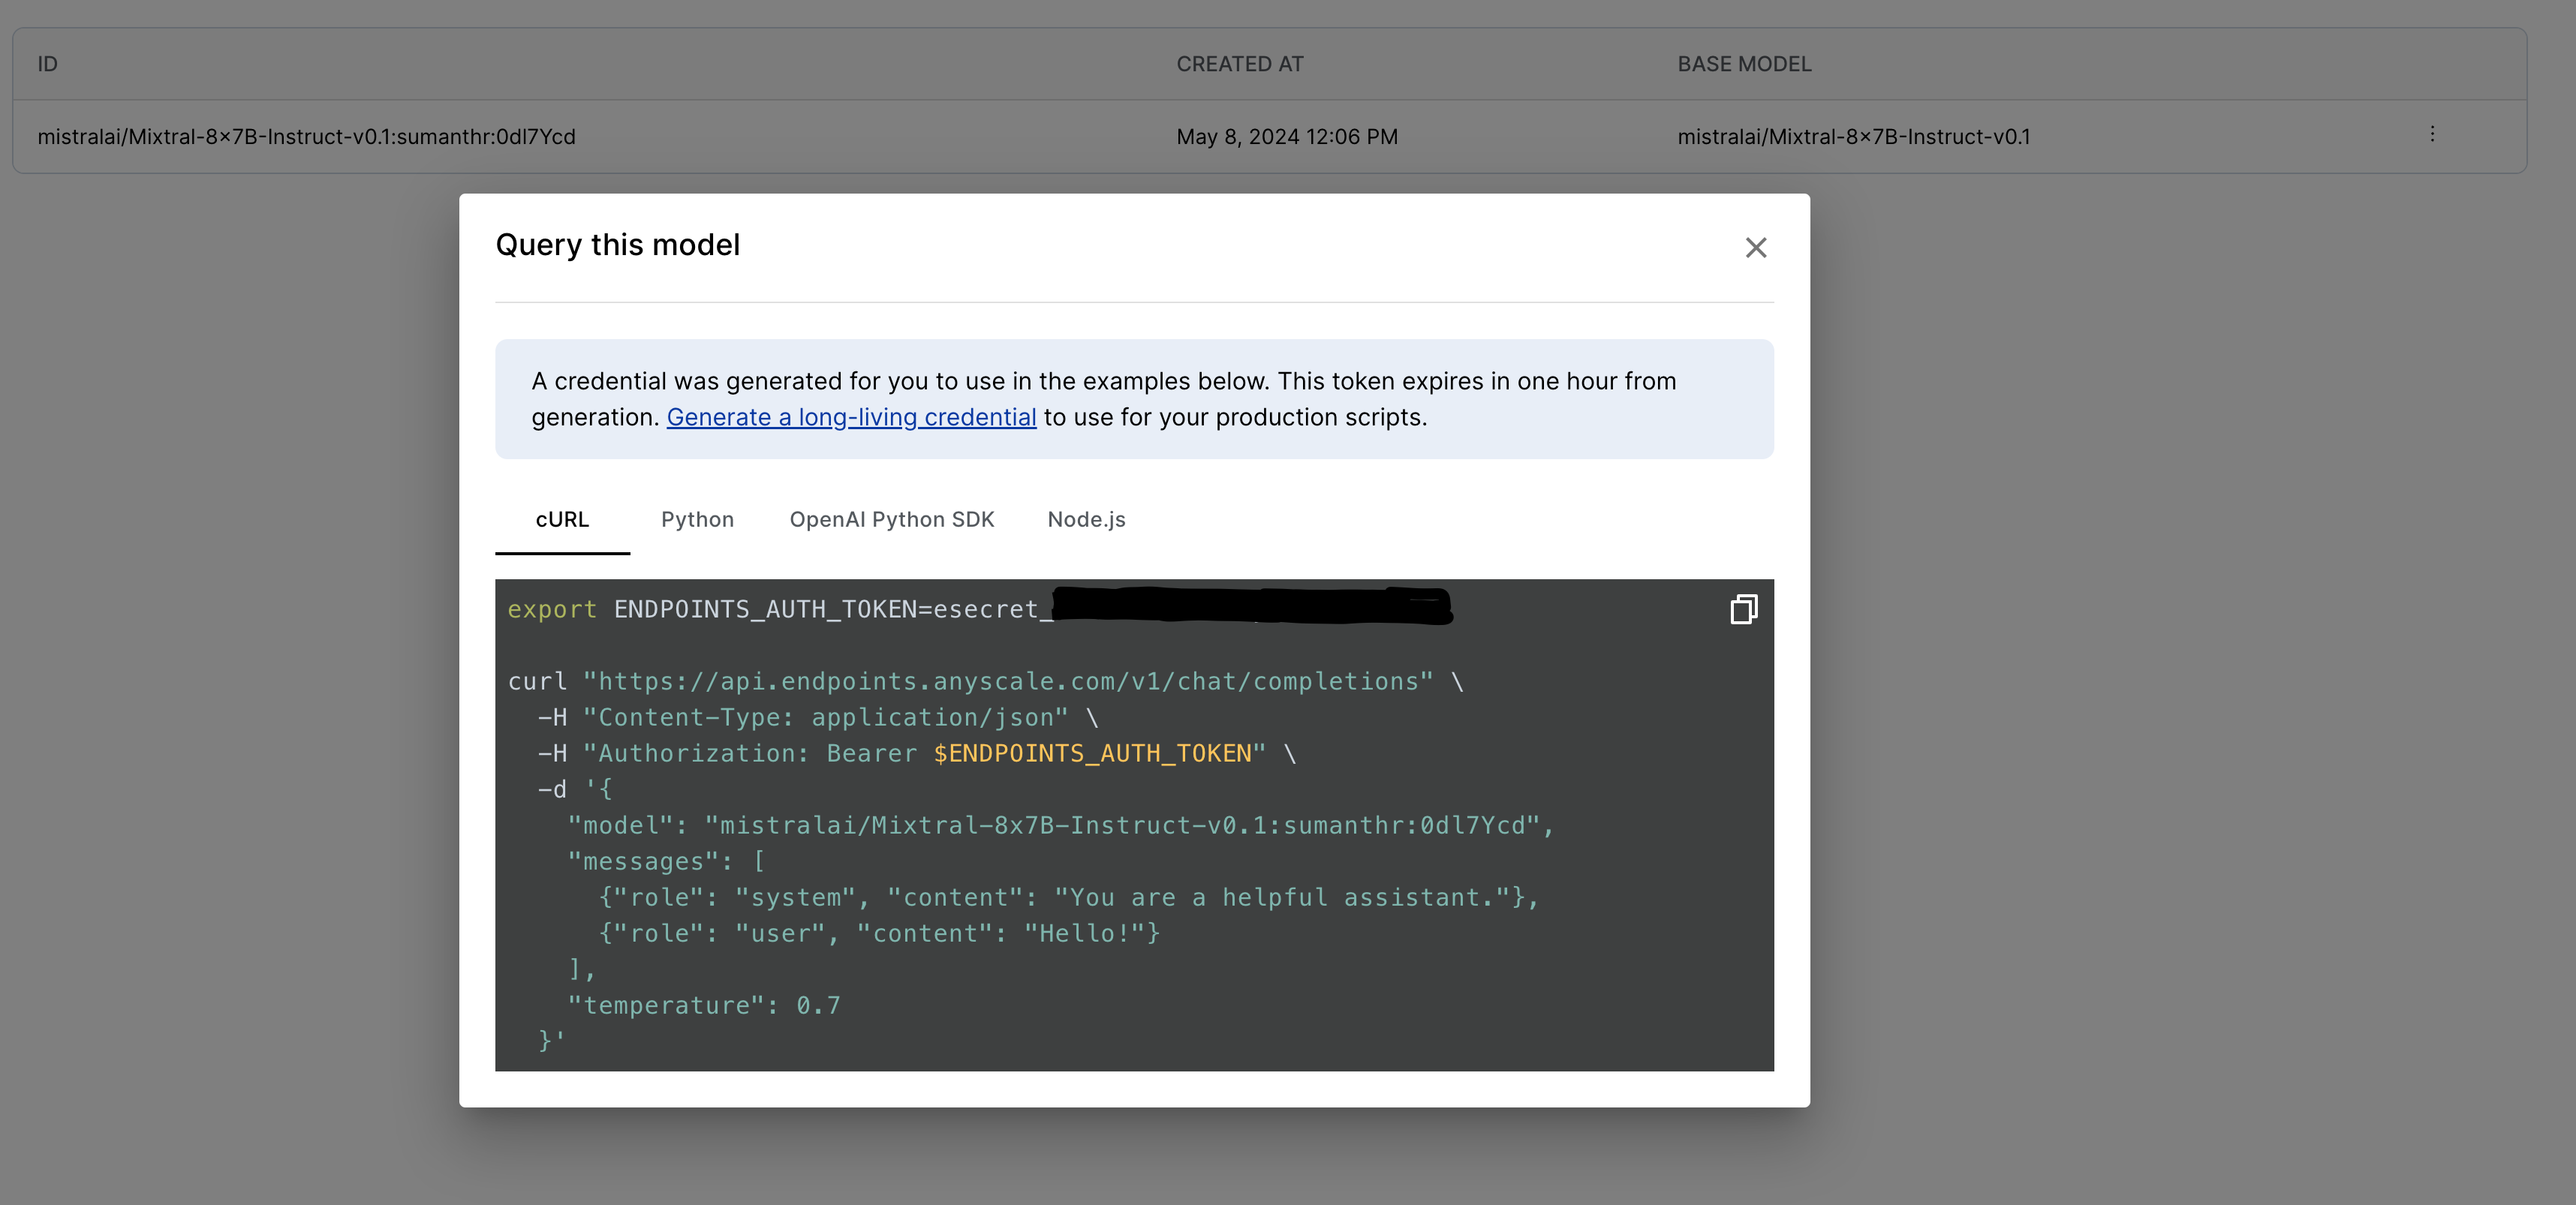

In [43]:
## This is only if you finetuned through serverless endpoints
ANYSCALE_API_BASE = "https://api.endpoints.anyscale.com/v1"
ANYSCALE_API_KEY = "esecret_yourKeyHere"
MODEL_ID = "yourModelIdHere" # make sure to not add a stray slash "/"" at the end!

### (Optional) Try out the model via Playground

You can try out your new model in the Playground: https://console.anyscale.com/v2/playground . In the model dropdown, you should be able to see your finetuned model as shown below

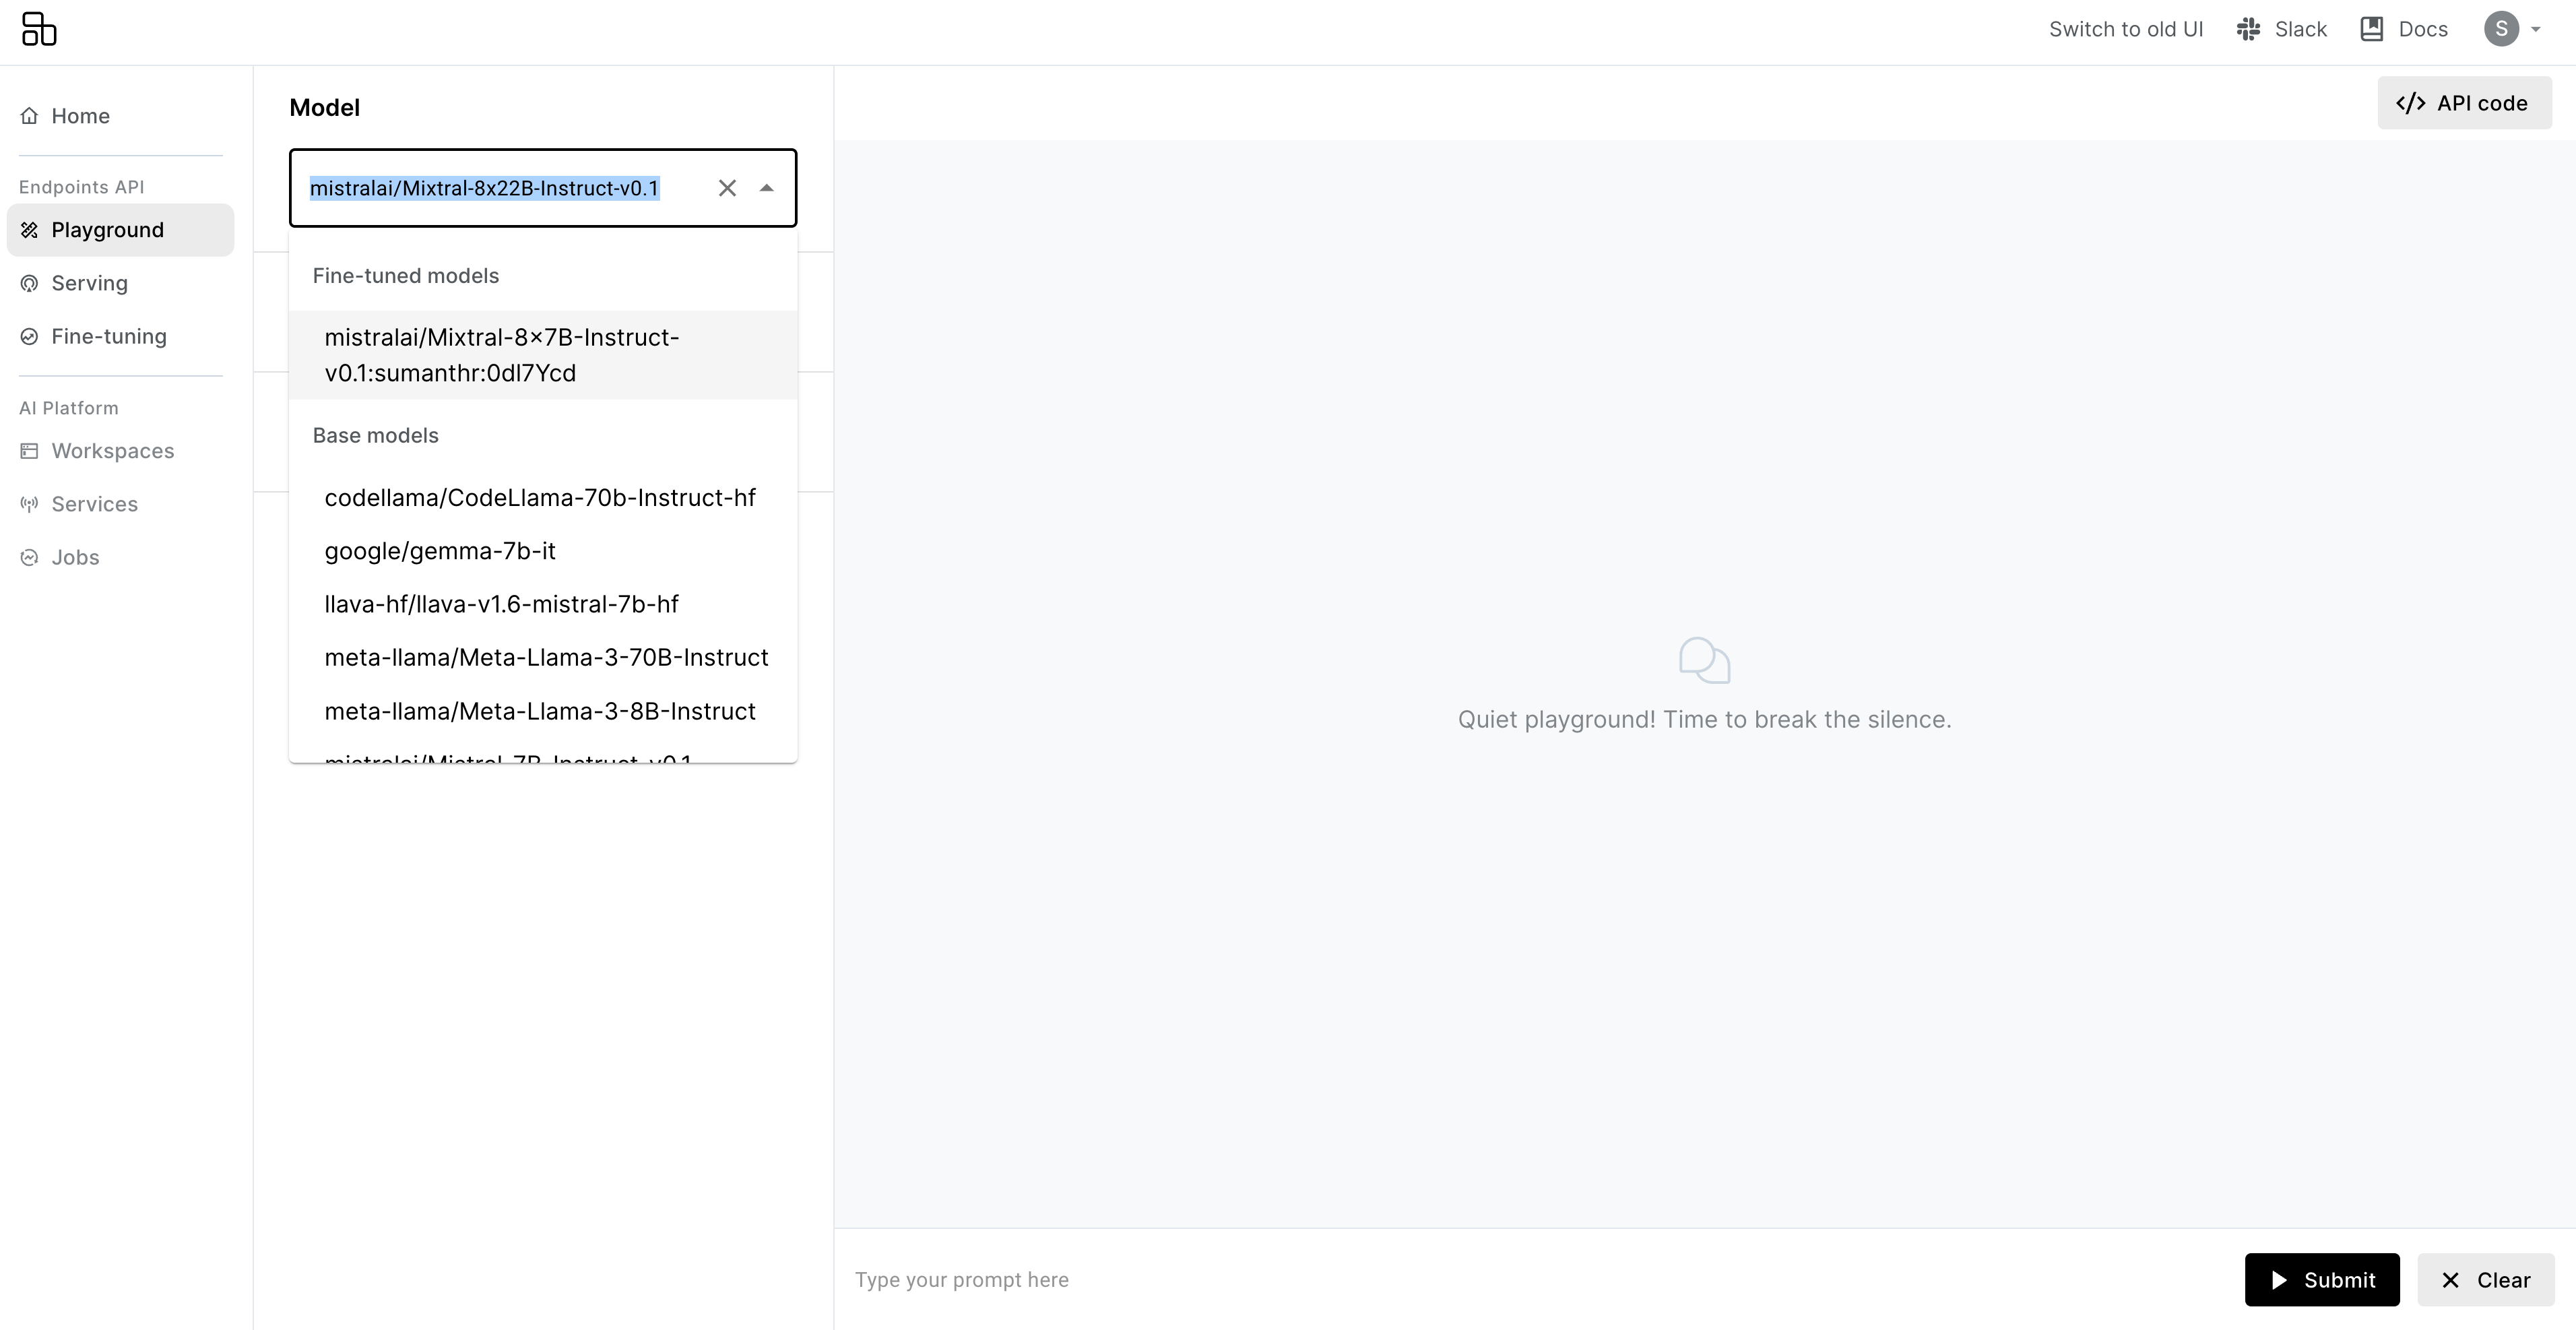

# Step 4: Evaluation

Let's evaluate our trained model with GPT-4 as a baseline. 


## Evaluation strategy

Evaluation of function calling capability is non-trivial, given that we're looking to extract structured data from an inherently unpredictable and unstructured stream of text. We will use the following simple evaluation strategy: The models are evaluated on the accuracy metric and their responses are graded as accurate if their response for each assistant entry in the conversation is correct. An assistant response is graded as correct under the below conditions:
1. In case the ground truth response contains no function call, then the model's response should also not have a function call. 
2. In case the ground truth response contains a function call, then the model's response should also have a function call. We do not check for the content of the response here. The assistant function call should further have the correct function name and the correct function arguments. 

The following psuedocode shows some of the different branching conditions considered during evaluation:

```
if(ground_truth has no function call):
    correct = (response has no function call)
else
    if response has no function call: 
        correct = False
    else
          if response.function_name != gt.function_name:
                correct = False
          else
                correct = (response.argument_dict == gt.argument_dict)
```



## Dataset formatting
We follow the same preprocessing as during training for the finetuned model hosted on Anyscale. For GPT-4, the tool calls and tool responses are parsed and formatted in the OpenAI format. 

We process the test dataset to have the following fields: 
1. `openai_messages` : the list of messages in the conversation for GPT-4. The user messages will be fed to the model one by one. The function responses have to be designated with the role "tool" here.
2. `anyscale_messages`: the list of messages in the conversation for our fine-tuned model.
3. `tools`: the list of tools to pass to the OpenAI model. 
4. `expected_responses` : the list of ground truth assistant responses in the conversation. 

In [9]:
# preprocess the test dataset for evaluation
modified_ds = test_ds.map(test_data_mapper)

## Evaluate

For evaluation, we initialise two parsers - one for each model - to handle obtaining chat completions from the respective API and parsing the result. Then, our evaluation logic takes care of matching the assistant response with the expected response and, if the response is incorrect, making note of the type of error (wrong intent, wrong function name, etc). Populate the API keys below and run the below code blocks to get evaluation results:

In [49]:
# enter your openai key below.
OPENAI_API_KEY = "yourApiKeyHere" 
# enter your Anyscale key below. If you finetuned through Anyscale endpoints, you can get the key here: https://console.anyscale.com/credentials. Otherwise, you should use the key from your Anyscale Service
ANYSCALE_API_KEY = "yourApiKeyHere" 

In [97]:
# initialize parsers
openai_parser = OpenAIResponseParser(api_key=OPENAI_API_KEY, api_base="https://api.openai.com/v1", model="gpt-4")
anyscale_parser = AnyscaleResponseParser(api_key=ANYSCALE_API_KEY, api_base=ANYSCALE_API_BASE, model=MODEL_ID) 

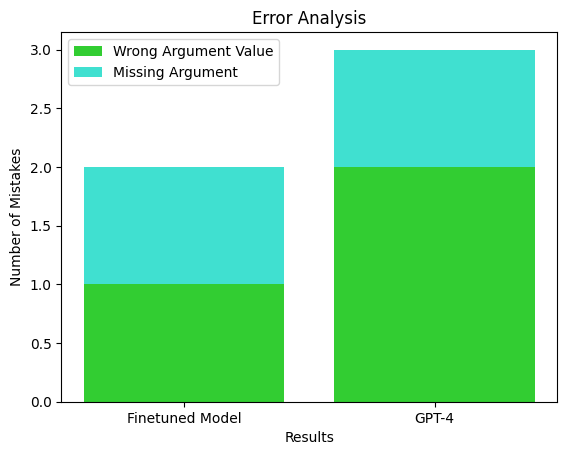

In [122]:
# evaluate both models and plot the results
results_gpt = evaluate_gpt(modified_ds, openai_parser)
results_finetuned = evaluate_finetuned(modified_ds, anyscale_parser)
plot_results(results_finetuned, results_gpt)

As you can see, our fine-tuned model is able to match GPT-4 level performance on this dataset. 

# Summary

If you got to the end, congrats! You have now fine-tuned an open source model rival GPT-4 on function calling. As a quick recap, here's what we demonstrated in this notebook:
1. Preprocesing a function calling dataset into a conversational format
2. Fine-tuning a language model through either the Anyscale Platform or through Anyscale Endpoints
3. Serving the fine-tuned model on Anyscale
4. Evaluating the model against GPT-4 and analysing the results.